In [45]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [141]:
import pandas as pd
import numpy as np
import os, sys
import argparse
from datetime import datetime
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate

In [142]:
#https://stackoverflow.com/questions/50204556/tkinter-tclerror-couldnt-connect-to-display-localhost10-0-when-using-wordc
matplotlib.use('Agg')

In [143]:
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/total.test.bed.gz'
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-10-28'

In [144]:
df=pd.read_csv(input_path, compression='gzip', sep='\t')

In [145]:
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

X = df_feature
y = df_class

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
print("Spliting is done!")
print("Before the pipeline:\n y_train:{},\n y_test: {}".format(Counter(y_train), Counter(y_test)))

# Define cross-validation fold
stratified_kfold = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
    
model_best = imbpipeline(steps=[('o', SMOTE(random_state=42)),
                                ('m', RandomForestClassifier(max_depth=5, min_samples_leaf=2,n_estimators=80, random_state=42))])

Spliting is done!
Before the pipeline:
 y_train:Counter({0: 799, 1: 799, 2: 399}),
 y_test: Counter({0: 200, 1: 200, 2: 100})


In [54]:
model_best.fit(X_train, y_train)

Pipeline(steps=[('o', SMOTE(random_state=42)),
                ('m',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=80, random_state=42))])

In [55]:
y_true, y_pred = y_test, model_best.predict(X_test)
test_score = model_best.score(X_test, y_test)
test_score

0.882

In [56]:
list(set(y_pred))

[0, 1, 2]

In [57]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[184,   0,  16],
       [  0, 179,  21],
       [ 14,   8,  78]])

# Confusion matrix visualization

In [58]:
cm = cf_matrix.copy()
target_names = ['5C', '5mC', '5hmC']

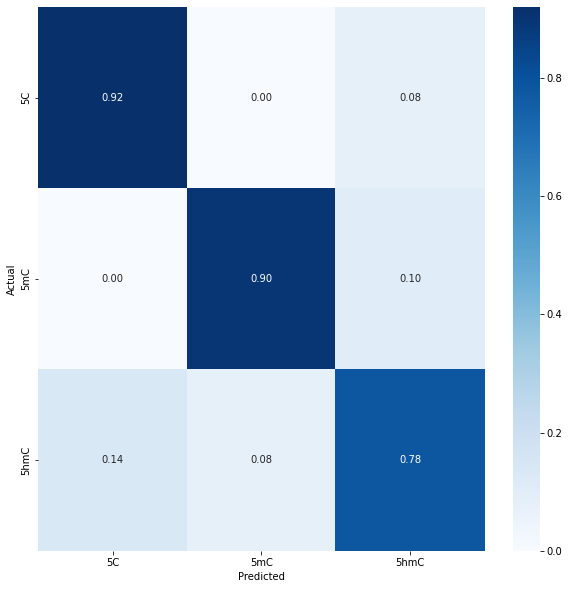

In [146]:
%matplotlib inline
import seaborn as sns
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, cmap="Blues",annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [148]:
def plot_cm(y_true, y_pred, filename, label, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
    
    cmn = pd.DataFrame(cmn, index=label, columns=label)
    cmn.index.name = 'True label'
    cmn.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues")
#    plt.savefig(filename)

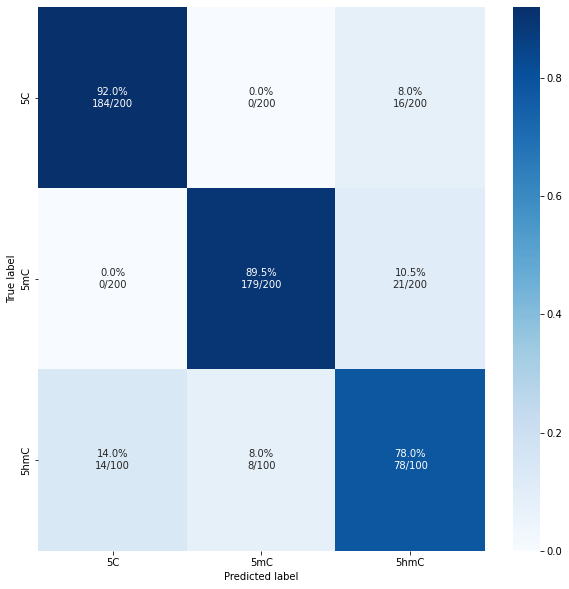

In [149]:
plot_cm(y_true, y_pred, 'test', ['5C', '5mC', '5hmC'], figsize=(10,10))

# Test code

In [134]:
def load_dataset(input_path):
    df=pd.read_csv(input_path, compression='gzip', sep='\t')
     
    #Splitting the data into independent and dependent variables
    df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
    df_class = df.loc[:,['label']].values
    df_class = np.squeeze(df_class) #Convert the label into 1d-array

    X = df_feature
    y = df_class

    #Split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)
    print("Before the pipeline:\n y_train:{},\n y_test: {}".format(Counter(y_train), Counter(y_test)))

    return X_train, X_test, y_train, y_test
    
def plot_cm(y_true, y_pred, filename, label, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
    
    cm = pd.DataFrame(cm, index=label, columns=label)
    cm.index.name = 'True label'
    cm.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues")
    plt.savefig(filename)
    
def reshape_data_1d(data):
    data = np.expand_dims(data, axis=2)
    return data

def validate(X_test, y_test, model_path, output_path, label, dataset = 'test'):
    # Define cross-validation fold
    stratified_kfold = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
    
    ###########Regenerate the result from save pipeline
    ####Testing dataset
    y_true, y_pred = y_test, model.predict(X_test)
    test_score = model.score(X_test, y_test)
    print('Test score:', test_score)
    
    ## Save the classification report
    class_report = "class_report_{}.csv".format(dataset)
    report = pd.DataFrame(classification_report(
        y_test, y_pred, target_names=label, output_dict=True)
                         ).transpose()
    report.to_csv(os.path.join(output_path, class_report), header = True, index= True, sep = ',', float_format='%.4f')
    
    ##Save the confusion matrix and plotting
    matrix_name = "confusion_matrix_{}.csv".format(dataset)
    _confusion_matrix = confusion_matrix(y_true, y_pred)
    _confusion_matrix = pd.DataFrame(_confusion_matrix, index=label,columns=label)
    _confusion_matrix.to_csv(os.path.join(output_path, matrix_name), header = True, index= True, sep = ',', float_format='%.4f')
    
    matrix_png = "confusion_matrix_{}.png".format(dataset)
    plot_cm(y_true, y_pred, os.path.join(output_path, matrix_png), label, figsize=(10,10))
    
    print("saving is done!")
    

In [130]:
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/total.test.bed.gz'
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-10-28'
model_path='/pod/2/li-lab/Ziwei/Nanopore/daily/result/rf_best_20211008.pkl'
import joblib

model = joblib.load(model_path)
X_train, X_test, y_train, y_test = load_dataset(input_path)      

Before the pipeline:
 y_train:Counter({0: 799, 1: 799, 2: 399}),
 y_test: Counter({0: 200, 1: 200, 2: 100})


In [135]:
y_test.shape, X_test.shape, y_train.shape, X_train.shape

((500,), (500, 3), (1997,), (1997, 3))

In [138]:
X_test_new = reshape_data_1d(X_test)
X_test_new.shape

(500, 3, 1)

In [112]:
stratified_kfold = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)


In [124]:
    
    ####Testing dataset
y_pred = model.predict(X_test)
test_score = model.score(X_test, y_test)
print('Test score:', test_score)

Test score: 0.882


In [129]:
validate(X_train, X_test, y_train, y_test, model_path, output_path, label = ['5C', '5mC', '5hmC'])

ValueError: Expected 2D array, got 1D array instead:
array=[0. 1. 0. ... 0. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.